In [31]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import regex as re


In [36]:
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Headless mode for background execution
driver = webdriver.Chrome(options=options)

# Go to the search results page
driver.get("https://www.amazon.in/s?k=soft+toys")

all_listitems = []  # To collect product divs across pages

while True:
	# Scroll down to load all lazy-loaded products
	driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
	try:
		WebDriverWait(driver, 10).until(
			EC.presence_of_element_located((By.CSS_SELECTOR, 'div[role="listitem"]'))
		)
	except Exception as e:
		print("Error waiting for product elements to load:", e)
		break

	# Load the rendered HTML into BeautifulSoup and collect items
	soup = BeautifulSoup(driver.page_source, "html.parser")
	listitem_divs = soup.find_all('div', {'role': 'listitem'})
	print(f"Collected {len(listitem_divs)} items from current page.")
	all_listitems.extend(listitem_divs)
	
	# Try to locate and click the Next button (Amazon uses "li.a-last a")
	try:
		next_page_button = driver.find_element(By.CSS_SELECTOR, "a.s-pagination-item.s-pagination-next.s-pagination-button.s-pagination-separator")
		next_page_button.click()
		# Optionally wait until the page changes; we wait until the first product becomes stale
		WebDriverWait(driver, 10).until(EC.staleness_of(listitem_divs[0]))
	except Exception as e:
		print("No more pages found or error navigating to next page:", e)
		break

driver.quit()
print(f"Total {len(all_listitems)} product items collected from all pages.")


Collected 54 items from current page.
No more pages found or error navigating to next page: 'NoneType' object is not callable
Total 54 product items collected from all pages.


In [20]:
# if listitem_divs:
# 	print(listitem_divs[0].prettify())
# else:
# 	print("No list items found.")


In [21]:
# Create a list to store all product dictionaries
products_list = []

for product in listitem_divs:
	# Extract Title
	title_elem = product.find('h2', class_='a-size-base-plus a-spacing-none a-color-base a-text-normal')
	title = title_elem.get_text(strip=True) if title_elem else None

	# Skip this product if the title is None
	if not title:
		continue

	# Extract Brand (using the first word of the title)
	brand = title.split()[0] if title else None

	# Extract Rating
	rating_elem = product.find('span', class_='a-icon-alt')
	rating_text = rating_elem.get_text(strip=True) if rating_elem else None
	rating = float(re.search(r'([\d.]+)', rating_text).group(1)) if rating_text and re.search(r'([\d.]+)', rating_text) else None

	# Extract Reviews
	reviews_elem = product.find('a', attrs={'aria-label': lambda x: x and "ratings" in x})
	reviews = int(re.search(r'(\d+)', reviews_elem.get_text(strip=True).replace(',', '')).group(1)) if reviews_elem and re.search(r'(\d+)', reviews_elem.get_text(strip=True)) else None

	# Extract Selling Price
	price_elem = product.find('span', class_='a-offscreen')
	selling_price = None
	if price_elem:
		price_text = price_elem.get_text(strip=True)
		price_text_clean = price_text.replace('₹', '').strip()
		try:
			selling_price = float(price_text_clean)
		except ValueError:
			selling_price = None

	# Extract Image URL
	image_elem = product.find('img', class_='s-image')
	image_url = image_elem['src'] if image_elem and image_elem.has_attr('src') else None

	# Extract Product URL
	link_elem = product.find('a', class_='a-link-normal s-no-outline')
	product_url = "https://www.amazon.in" + link_elem['href'] if link_elem and link_elem.has_attr('href') else None

	# --- Determine if Product is Sponsored ---
	# Approach 1: Search the entire text
	is_sponsored_text = bool(re.search(r'\bSponsored\b', product.get_text(), re.IGNORECASE))

	# Approach 2: Directly search for a span with the sponsored label
	sponsored_span = product.find('span', string=re.compile(r'\bSponsored\b', re.IGNORECASE))
	is_sponsored_element = True if sponsored_span else False

	# You can combine both checks or choose one:
	is_sponsored = is_sponsored_text or is_sponsored_element

	# Build the dictionary
	product_dict = {
		"Title": title,
		"Brand": brand,
		"Reviews": reviews,
		"Rating": rating,
		"Selling Price": selling_price,
		"Image URL": image_url,
		"Product URL": product_url,
		"Sponsored": True, # Here is the fault 		
	}

	products_list.append(product_dict)

# Convert to DataFrame and save as CSV
df = pd.DataFrame(products_list)
df.to_csv('amazon_soft_toys_data.csv', index=False)


In [22]:
df = pd.read_csv('amazon_soft_toys_data.csv')
df.head()


,Title,Brand,Reviews,Rating,Selling Price,Image URL,Product URL,Sponsored
0,Storio Toy Octopus Plushie Reversible Soft Toy...,Storio,1565,4.2,179.0,https://m.media-amazon.com/images/I/51nqXz7iWr...,https://www.amazon.in/Storio-Octopus-Plushie-R...,True
1,Babique Cat Flower Plush Soft Toy Cute Kids An...,Babique,1210,4.0,217.0,https://m.media-amazon.com/images/I/61QnIuUiOg...,https://www.amazon.in/Babique-Flower-Plush-Ani...,True
2,Niku Rabbit with Chain Reversible Bunny Rabbit...,Niku,622,4.1,351.0,https://m.media-amazon.com/images/I/613ls1KV-H...,https://www.amazon.in/Niku-Reversible-Stuffed-...,True
3,Babique Dog Sitting Plush Soft Toy Cute Kids A...,Babique,1233,4.0,179.0,https://m.media-amazon.com/images/I/51h6wRH0lp...,https://www.amazon.in/Babique-Sitting-Plush-An...,True
4,Babique Unicorn Teddy Bear Plush Soft Toy Cute...,Babique,9322,4.2,156.0,https://m.media-amazon.com/images/I/51C5TrSt-G...,https://www.amazon.in/Babique-Unicorn-Stuffed-...,True


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          48 non-null     object 
 1   Brand          48 non-null     object 
 2   Reviews        48 non-null     int64  
 3   Rating         48 non-null     float64
 4   Selling Price  48 non-null     float64
 5   Image URL      48 non-null     object 
 6   Product URL    48 non-null     object 
 7   Sponsored      48 non-null     bool   
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 2.8+ KB


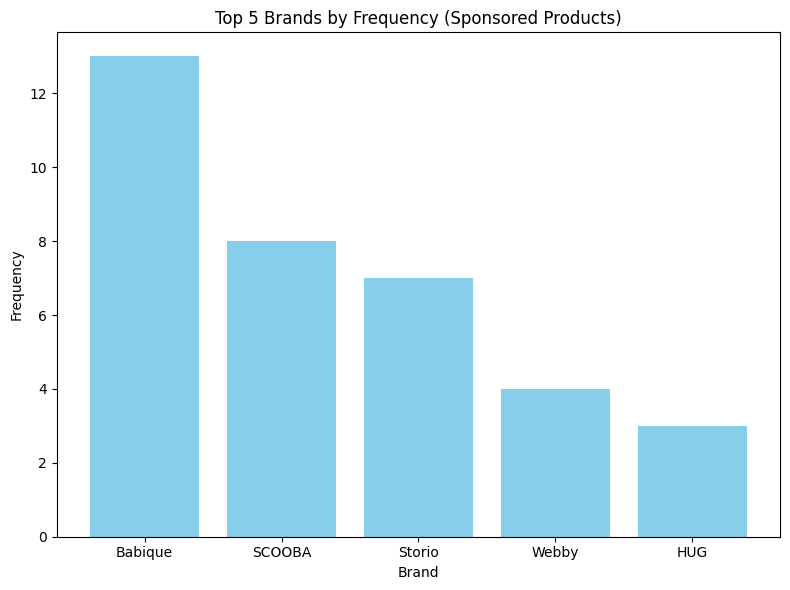

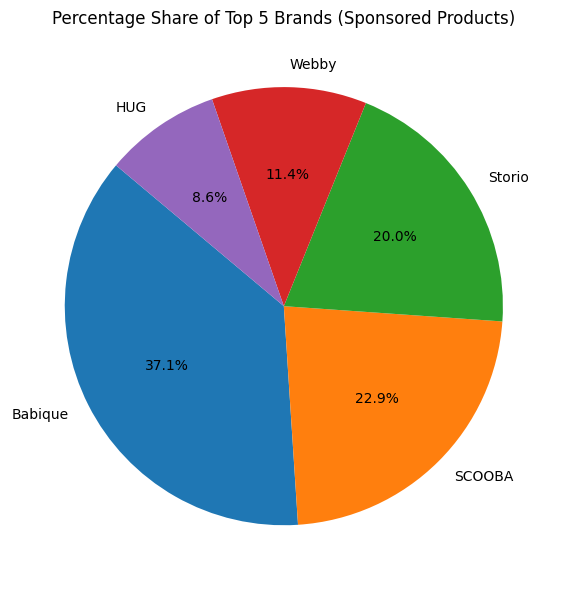

Top Performing Brands in Sponsored Products:
     Brand  Frequency
0  Babique         13
1   SCOOBA          8
2   Storio          7
3    Webby          4
4      HUG          3

Average Rating by Brand:
         Brand    Rating
0       Amazon  4.400000
14      pikipo  4.400000
13       Webby  4.325000
2      DearJoy  4.300000
12      Storio  4.214286
1      Babique  4.130769
9       SCOOBA  4.112500
7         Niku  4.100000
11  Storescent  4.100000
3       Future  4.100000
4          HUG  4.000000
10      SIVIGE  4.000000
6      Mommers  4.000000
8        Richy  4.000000
5         Mini  2.500000


In [25]:
sponsored_df = df[df['Sponsored'] == True].copy()
# Drop rows with missing Brand or Rating values
sponsored_df = sponsored_df.dropna(subset=['Brand', 'Rating'])

# -------------------------------------------------
# 1. Brand Frequency: Count how many times each brand appears 
brand_freq = sponsored_df['Brand'].value_counts().reset_index()
brand_freq.columns = ['Brand', 'Frequency']

# For visualization, choose the top 5 brands by frequency
top5_brands_freq = brand_freq.head(5)

# 2. Average Rating by Brand: Compute average rating for each brand
brand_rating = sponsored_df.groupby('Brand', as_index=False)['Rating'].mean()
brand_rating = brand_rating.sort_values(by='Rating', ascending=False)

# -------------------------------------------------
# Visualization: Bar chart for top 5 brands by frequency
plt.figure(figsize=(8,6))
plt.bar(top5_brands_freq['Brand'], top5_brands_freq['Frequency'], color='skyblue')
plt.title('Top 5 Brands by Frequency (Sponsored Products)')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Visualization: Pie chart for percentage share of the top brands by frequency
plt.figure(figsize=(8,6))
plt.pie(top5_brands_freq['Frequency'], labels=top5_brands_freq['Brand'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage Share of Top 5 Brands (Sponsored Products)')
plt.tight_layout()
plt.show()

# Print actionable insights
print("Top Performing Brands in Sponsored Products:")
print(top5_brands_freq)

print("\nAverage Rating by Brand:")
print(brand_rating)


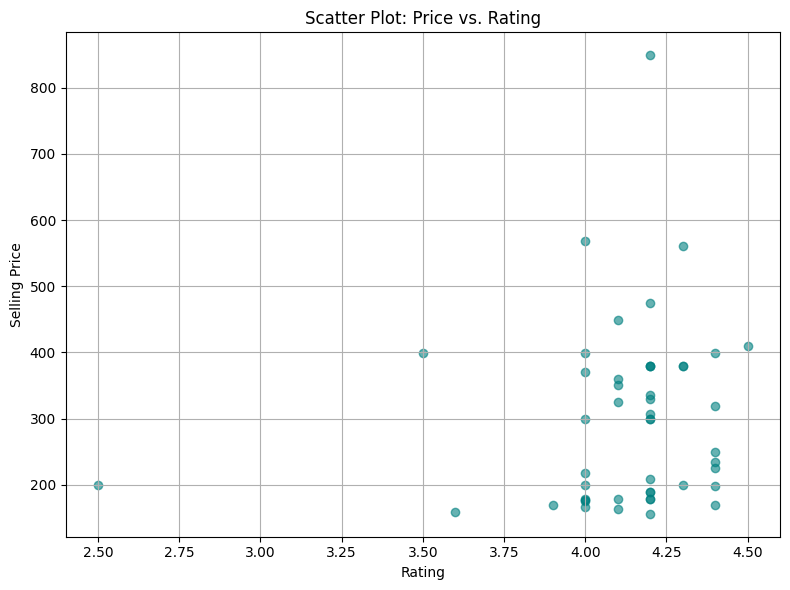

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14696\3765765250.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_range = price_rating_df.groupby('Rating Range')['Selling Price'].mean().reset_index()


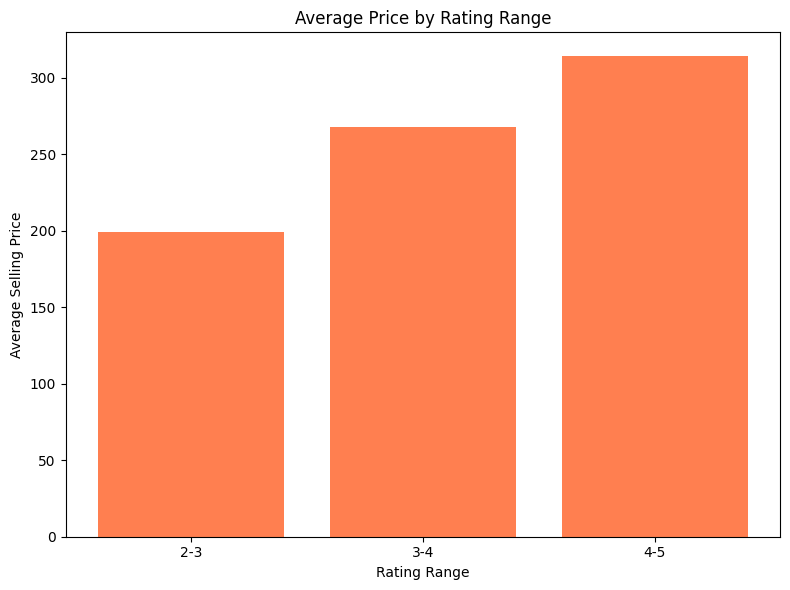

Average Selling Price by Rating Range:
  Rating Range  Selling Price
0          0-2            NaN
1          2-3     199.000000
2          3-4     267.615385
3          4-5     314.058824


In [26]:
# Ensure price and rating columns are numeric and drop rows with missing values
df['Selling Price'] = pd.to_numeric(df['Selling Price'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
price_rating_df = df.dropna(subset=['Selling Price', 'Rating'])

# -------------------------------
# Scatter plot: Price vs. Rating (outlier analysis)
plt.figure(figsize=(8,6))
plt.scatter(price_rating_df['Rating'], price_rating_df['Selling Price'], alpha=0.6, color='teal')
plt.xlabel('Rating')
plt.ylabel('Selling Price')
plt.title('Scatter Plot: Price vs. Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Bar chart: Average Price by Rating Range
# Define rating bins; adjust the bins as needed based on your data
bins = [0, 2, 3, 4, 5]
labels = ['0-2', '2-3', '3-4', '4-5']
price_rating_df['Rating Range'] = pd.cut(price_rating_df['Rating'], bins=bins, labels=labels, include_lowest=True)

# Calculate the average price for each rating range
avg_price_by_range = price_rating_df.groupby('Rating Range')['Selling Price'].mean().reset_index()

plt.figure(figsize=(8,6))
plt.bar(avg_price_by_range['Rating Range'], avg_price_by_range['Selling Price'], color='coral')
plt.xlabel('Rating Range')
plt.ylabel('Average Selling Price')
plt.title('Average Price by Rating Range')
plt.tight_layout()
plt.show()

# Print actionable insights with the average price ranges
print("Average Selling Price by Rating Range:")
print(avg_price_by_range)


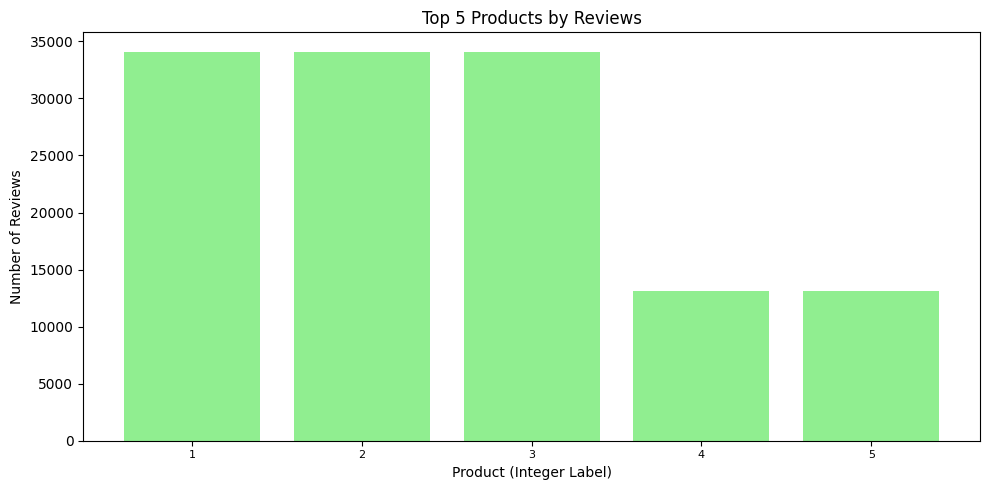

Mapping for Top Reviewed Products (Integer Label: Title):
1: HUG 'n' FEEL SOFT TOYS Long Soft Lovable Huggable Cute Giant Life Size Teddy Bear Plush & Stuffed Toys (35cm, Avocado)
2: HUG 'n' FEEL SOFT TOYS Unicorn, Soft Toy, Baby Toys, Kids Toy, Soft Toy, Toy for Girl, Birthday Gift for Girl Boys, Toy Gift for Girls, Kids Toys for Boys Girl, Toys Gift Items, (30cm, Pink)
3: HUG 'n' FEEL SOFT TOYS Random Color Baby Penguin Soft Toy 25 cm
4: Amazon Brand - Jam & Honey Soft Penguin Plush Toy for Kids | Soft Toy for Boys and Girls | Super-Soft and Safe| Ideal for Gifting | Height 17 cm | Black and White
5: Amazon Brand - Jam & Honey Dinosaur, Cute, Plush/Soft Toy, Suitable for Boys, Girls and Kids, Super-Soft, Safe, 34 cm (Green & Yellow)


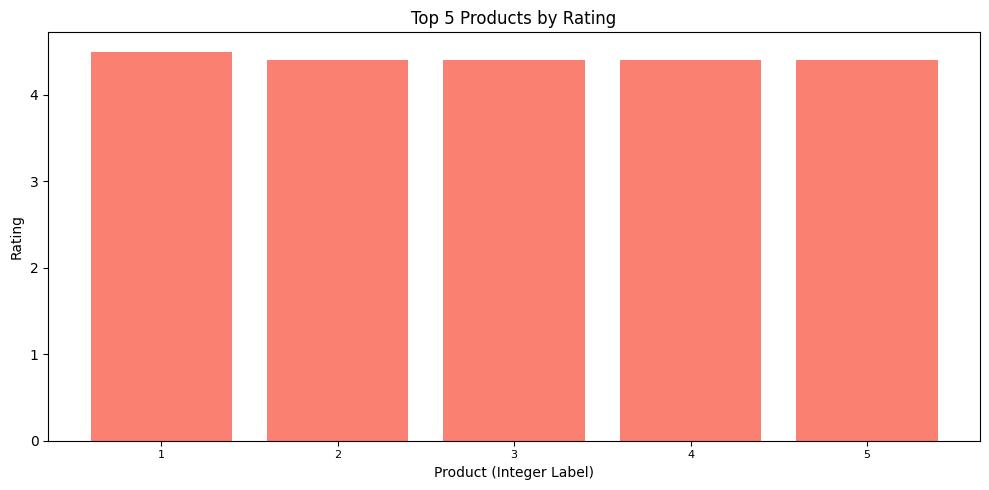

Mapping for Top Rated Products (Integer Label: Title):
1: Webby Plush Husky Dog Stuffed Animal Puppy Soft Toy, Adorable Gifts for Kids and Adult, Glitter Eyes Soft Toy, 35CM (Grey)
2: Amazon Brand - Jam & Honey Soft Penguin Plush Toy for Kids | Soft Toy for Boys and Girls | Super-Soft and Safe| Ideal for Gifting | Height 17 cm | Black and White
3: Babique Elephant Sitting Plush Soft Toy Cute Kids Animal Home Decor Boys/Girls (Blue, 30 cm)
4: Webby Soft Animal Plush Elephant Toy 20cm, Blue & Grey
5: Amazon Brand - Jam & Honey Dinosaur, Cute, Plush/Soft Toy, Suitable for Boys, Girls and Kids, Super-Soft, Safe, 34 cm (Green & Yellow)


In [27]:
# Convert columns to numeric
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Drop rows with missing values in Title, Reviews, or Rating
df = df.dropna(subset=['Title', 'Reviews', 'Rating'])

# Get Top 5 Products by Reviews and by Rating
top_reviewed = df.sort_values(by='Reviews', ascending=False).head(5).reset_index(drop=True)
top_rated = df.sort_values(by='Rating', ascending=False).head(5).reset_index(drop=True)

# Create an integer mapping for the product titles
reviewed_mapping = {i+1: title for i, title in enumerate(top_reviewed['Title'])}
rated_mapping = {i+1: title for i, title in enumerate(top_rated['Title'])}

# --- Visualization: Bar Chart for Most-Reviewed Products using integer labels ---
x_rev = list(reviewed_mapping.keys())
y_rev = top_reviewed['Reviews']

plt.figure(figsize=(10, 5))
plt.bar(x_rev, y_rev, color='lightgreen')
plt.xticks(x_rev, x_rev, fontsize=8)
plt.xlabel("Product (Integer Label)", fontsize=10)
plt.ylabel("Number of Reviews", fontsize=10)
plt.title("Top 5 Products by Reviews", fontsize=12)
plt.tight_layout()
plt.show()

print("Mapping for Top Reviewed Products (Integer Label: Title):")
for key, val in reviewed_mapping.items():
    print(f"{key}: {val}")

# --- Visualization: Bar Chart for Top-Rated Products using integer labels ---
x_rat = list(rated_mapping.keys())
y_rat = top_rated['Rating']

plt.figure(figsize=(10, 5))
plt.bar(x_rat, y_rat, color='salmon')
plt.xticks(x_rat, x_rat, fontsize=8)
plt.xlabel("Product (Integer Label)", fontsize=10)
plt.ylabel("Rating", fontsize=10)
plt.title("Top 5 Products by Rating", fontsize=12)
plt.tight_layout()
plt.show()

print("Mapping for Top Rated Products (Integer Label: Title):")
for key, val in rated_mapping.items():
    print(f"{key}: {val}")
    